# Cardiovascular Data EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import itertools
import ydata_profiling
import collections
%matplotlib inline
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)

### Data description: There are 3 types of input features:
    Age	(Objective Feature) age-int (days) 
    Height	(Objective Feature) height-int (cm) 
    Weight	(Objective Feature) weight-float (kg) 
    Gender	(Objective Feature) gender-categorical code 
    Systolic [blood pressure] (Examination Feature)	ap_hi-int 
    Diastolic [blood pressure] (Examination Feature) ap_lo-int 
    Cholesterol (Examination Feature) cholesterol-categorical code
            1: normal, 2: above normal, 3: well above normal 
    Smoking	(Subjective Feature) smoke-binary

Loading the dataset and displaying the top 3 entries

In [2]:
cardio_base=pd.read_csv('cardio_base.csv')
print(cardio_base.shape)
cardio_base.head(3)

(70000, 9)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,smoke
0,0,18393,2,168,62.0,110,80,1,0
1,1,20228,1,156,85.0,140,90,3,0
2,2,18857,1,165,64.0,130,70,3,0


In [3]:
# Dropping id column as it's irrelevant in our analysis
cardio_base.drop(['id'],axis=1,inplace=True)

### Pandas Profiling

In [4]:
ydata_profiling.ProfileReport(cardio_base)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the Pandas Profiling report we have the following overview of our dataset:
1. Dataset has 62 redundant entries which needs to be dropped.
2. We have 5 numeric and 3 categorical columns(gender, cholesterol & smoke).
3. ap_hi & ap_lo are highly correlated so, we may be drop one of them accordingly.
4. ap_hi & ap_lo are not normally distributed. If required we may try transforming the data into normal distribution.
5. Our dependentent variable Smoke is highly imbalanced, we may have to produce synthetic data to balance it.


## Univariate analysis

In [5]:
#dropping diplicates
cardio_base.drop_duplicates(keep='first',inplace=True)

# Dividing age by 365 and apply floor function to round it into years.
cardio_base['age']=np.floor(cardio_base['age']/365).astype(np.int64)

# Apply absolute functon on ap_hi & ap_lo, as it has negative values which seems to be human error.
cardio_base['ap_hi']=np.abs(cardio_base['ap_hi'])
cardio_base['ap_lo']=np.abs(cardio_base['ap_lo'])
print(cardio_base.info())
cardio_base.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69938 entries, 0 to 69999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69938 non-null  int64  
 1   gender       69938 non-null  int64  
 2   height       69938 non-null  int64  
 3   weight       69938 non-null  float64
 4   ap_hi        69938 non-null  int64  
 5   ap_lo        69938 non-null  int64  
 6   cholesterol  69938 non-null  int64  
 7   smoke        69938 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 4.8 MB
None


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,smoke
count,69938.000000,69938.000000,69938.000000,69938.000000,69938.000000,69938.000000,69938.000000,69938.000000
mean,52.839973,1.349695,164.359190,74.213050,128.848838,96.647302,1.367182,0.088207
std,6.767699,0.476877,8.212801,14.399248,154.059223,188.554353,0.680461,0.283597
min,29.000000,1.000000,55.000000,10.000000,1.000000,0.000000,1.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,0.000000
50%,53.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,0.000000
max,64.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,1.000000


Age is measured in years, height is in centimeters. Let's look at the numerical variables and how are they spread among target class. 
For example, at what age does probability of having chlesterol type-3 increases than having colesterol type-2?

If we look more closely to height and weight columns, we will notice that minimum height is 55 cm and minimum weight is 10 kg. That has to be an error, since minimum age is 29 years. On the other hand, the maximum height is 250 cm and the highest weight is 200 kg, which might be irrelevant, when generilizing data. To deal with these errors, we can remove outliers.

In [6]:
#handling outliers
def trim_outliers(col,df):
    df=df.copy(deep=True)
    if isinstance(col,list):
        for name in col:
            iqr=stats.iqr(df[name])
            lb=df[name].quantile(0.25)-(1.5*iqr)
            ub=df[name].quantile(0.75)+(1.5*iqr)
            mask=~((df[name]>=lb) & (df[name]<=ub))
            df.loc[mask,name]=df.loc[~mask,name].mean() 
    else:
        iqr=stats.iqr(df[col])
        lb=df[col].quantile(0.25)-(1.5*iqr)
        ub=df[col].quantile(0.75)+(1.5*iqr)
        mask=~((df[col]>=lb) & (df[col]<=ub))
        df[col].loc[mask,col]=df.loc[~mask,col].mean()
    return df

In [7]:
cardio_base=trim_outliers(['height','weight','ap_hi','ap_lo'],cardio_base)

In addition, in some cases diastolic pressure is higher than systolic, which is also incorrect. How many records are inaccurate in terms of blood pressure?

In [8]:
print("Diastilic pressure is higher than systolic one in {0} cases".format(cardio_base[cardio_base['ap_lo']> cardio_base['ap_hi']].shape[0]))

Diastilic pressure is higher than systolic one in 2 cases


In [9]:
# Dropping where ap_hi<ap_lo
cardio_base.drop(cardio_base.loc[cardio_base['ap_hi']<cardio_base['ap_lo']].index,axis=0,inplace=True)

<AxesSubplot: xlabel='age', ylabel='Count'>

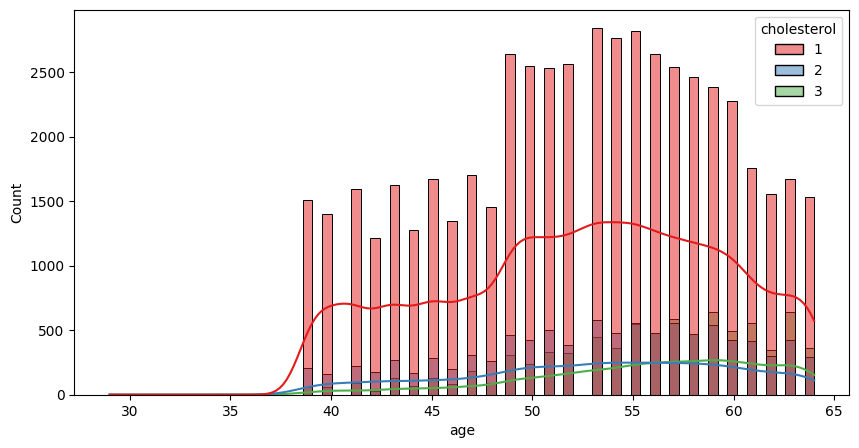

In [10]:
# Distribution
plt.figure(figsize=(10,5))
sns.histplot(x='age', hue='cholesterol', data = cardio_base,kde=True,palette="Set1")

It can be observed that people above age 56 years have higher probability of having cholesterol type-3 than type-2.

Let's look at categorical variables in the dataset and their distribution:

<AxesSubplot: xlabel='variable', ylabel='count'>

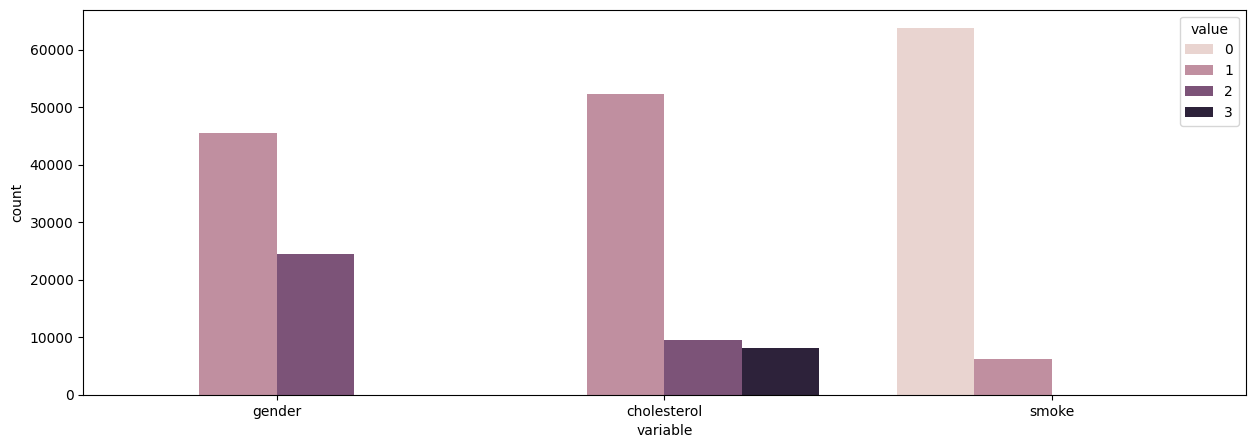

In [11]:
plt.figure(figsize=(15,5))
sns.countplot(x='variable',hue='value',data=cardio_base.drop(columns=['ap_hi','ap_lo','age','height','weight']).melt())

## Bivariate analysis
It may be useful to split categorical variables by target class:

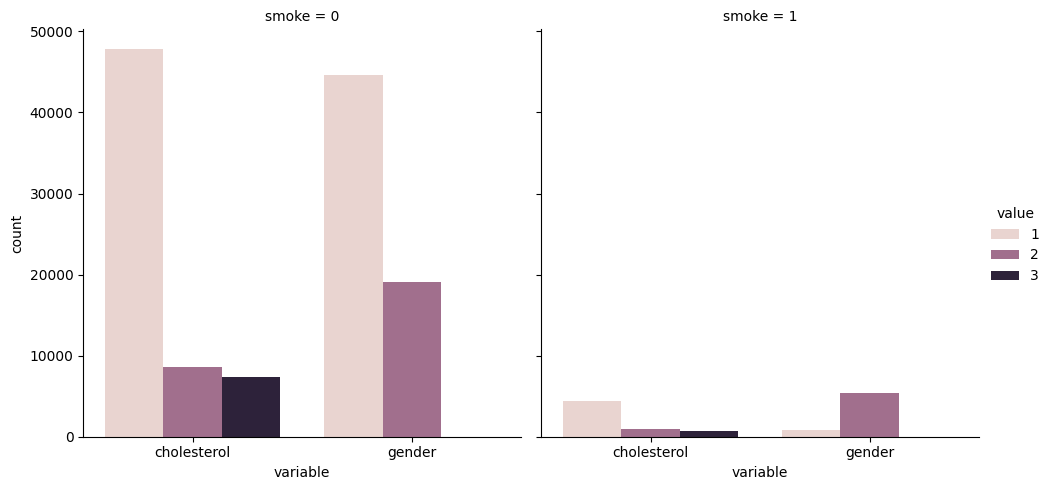

In [12]:
sns.catplot(data=pd.melt(cardio_base,id_vars=['smoke'],value_vars=['cholesterol','gender']),x='variable',hue='value',col='smoke',kind='count')

It can be seen that there's no significant impact of smoke on cholesterol level.

To figure out whether "1" stands for women or men in gender column, let's calculate the mean of height per gender. We assume that men are higher than women on average.

In [13]:
cardio_base.groupby('gender')['height'].mean()

gender
1    161.480880
2    169.829153
Name: height, dtype: float64

Average height for "2" gender is greater, than for "1" gender, therefore "1" stands for women and "2" stands for men. Let's see how many men and women presented in the dataset:

In [14]:
cardio_base.value_counts('gender')

gender
1    45481
2    24455
dtype: int64

Who more often report smoking - men or women?

In [15]:
cardio_base.groupby('gender')['smoke'].sum()

gender
1     813
2    5355
Name: smoke, dtype: int64

So, men smoke more frequently on average. Next, are the target variables balanced:

In [16]:
pd.crosstab(cardio_base['smoke'],cardio_base['gender'],normalize=True) 

gender,1,2
smoke,,
0,0.638698,0.273107
1,0.011625,0.076570


In [17]:
# Function to generate plots for continuous variables
def plot_dists(data:pd.DataFrame):
    fig=plt.figure(figsize=(13,7),layout='tight')
    for i,col in enumerate(data.drop(['gender','cholesterol','smoke'],axis=1),1):
        ax=plt.subplot(2,3,i,title=col.upper())
        if data[col].nunique()<=5:
            sns.countplot(x=data[col])
        else:
            sns.histplot(data[col],bins='auto',kde=True)
            ax.vlines([data[col].mean(),data[col].median()],0,1,transform=ax.get_xaxis_transform(),colors=['r','g'],linestyles='dashed')
    plt.show()

def plot_boxplot(data:pd.DataFrame):
    fig=plt.figure(figsize=(8,10),layout='tight')
    for i,col in enumerate(data.drop(['gender','cholesterol','smoke'],axis=1),1):
        ax=plt.subplot(3,3,i,title=col.upper())
        sns.boxplot(data.loc[data[col].notna(),col])
    plt.show()

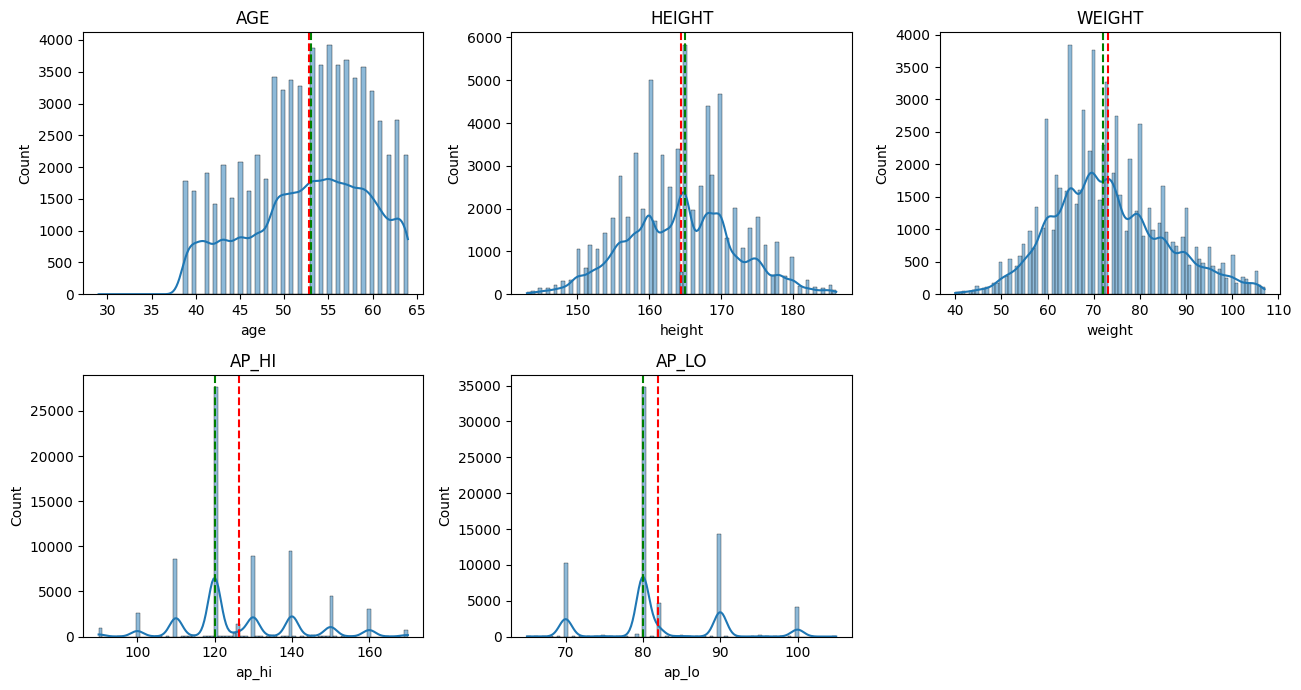

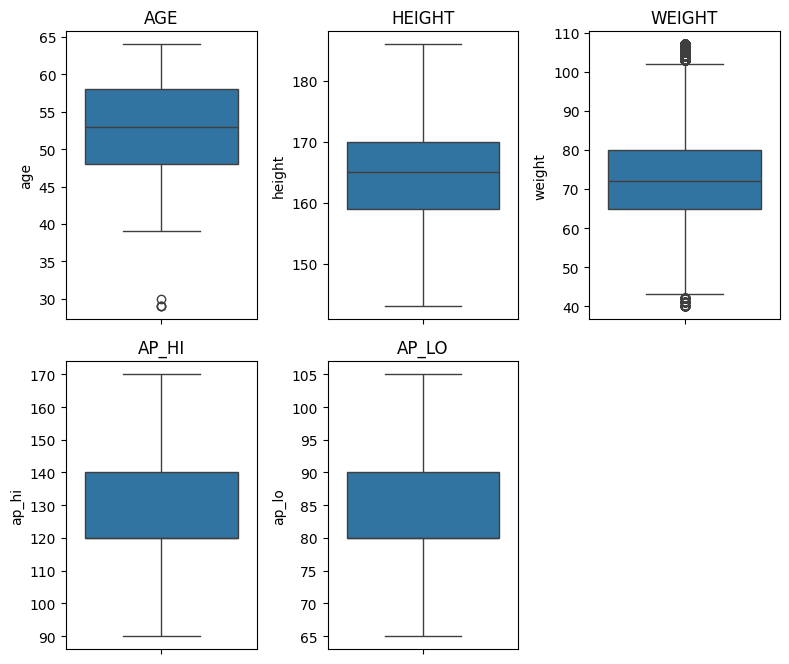

In [18]:
plot_dists(cardio_base)
plot_boxplot(cardio_base)

### Checking normality, skewness & kurtosis of distribution

In [20]:
# # Function to check
# def normality_test(data):
#     print(f'Mean: {np.mean(data)}')
#     print(f'Standard_deviation: {np.std(data)}')
#     print('\n')

#     # H0- Normally distributed
#     # H1- Not Normally distributed

#     ## Shipro_wilk test (n<50)
#     # stat, pvalue=stats.shapiro(data)
#     # print(f'Shapiro-Wilk Stats: {stat}')
#     # print(f'Shapiro-Wilk P-value: {pvalue}')

#     # Kolmogrov-Smirnov (n>50)
#     stat, pvalue=stats.kstest(data,cdf='norm')
#     print(f'K-S Stats: {stat}')
#     print(f'K-S P-value: {pvalue}')

#     if pvalue>0.05:
#         print("We fail to reject null hypothesis, thus data is normally distributed")
#     else:
#          print("We reject null hypothesis, thus data is not-normally distributed")

#     #Skewness & Kurtosis
#     print('\n')
#     print(f'Skewness: {stats.skew(data)}')
#     print(f'Kurtosis: {stats.kurtosis(data)}')
#     print('\n')
#     print('Skewness close to 0 suggest a symmetrical distribution')
#     print('Skewness > 0.5 suggest a positively skewed (Values Skewed right)')
#     print('Skewness < -0.5 suggest a negatively skewed (Values Skewed left)')
#     print('\n')
#     print('Kurtosis close to 3 indicates a normally distribution (mesokurtic)')
#     print('Kurtosis < 3 (platykurtic) indicates less peaked distribution than a normally distribution')
#     print('Kurtosis > 3 (leptoykurtic) indicates more peaked distribution than a normally distribution')

#     #probability plot (pp-plot)
#     print('\n')
#     plt.figure(figsize=(8,5))
#     stats.probplot(data,dist='norm',plot=plt)
#     plt.xlabel('Sample Quantiles')
#     plt.xlabel('Theoretical Quantiles')
#     plt.title('PP-Plot')
#     plt.grid(True)
#     plt.show()
#     print('Data points on a straight line suggests a normally distributed data') 
#     print('\n') 

In [19]:
def normality_test(data, alpha=0.05):
  """
  Performs normality tests and visualizes the distribution of the data.
  
  Prints:
      Descriptive statistics, normality test results, interpretation of skewness and kurtosis,
      and a PP-plot.
  """
  print(f'Mean: {np.mean(data)}')
  print(f'Standard_deviation: {np.std(data)}')
  print('\n')

  # Normality test (using normaltest for all data sizes)
  stat, pvalue = stats.normaltest(data)
  print(f'Normality Test Stats: {stat}')
  print(f'Normality Test P-value: {pvalue}')

  if pvalue > alpha:
      print(f"We fail to reject the null hypothesis (alpha={alpha}), data seems normally distributed.")
  else:
      print(f"We reject the null hypothesis (alpha={alpha}), data likely not normally distributed.")

  # Skewness & Kurtosis
  print('\n')
  print(f'Skewness: {stats.skew(data)}')
  print(f'Kurtosis: {stats.kurtosis(data)}')
  print('\n')
  print('Skewness:')
  print('  - Values close to 0 suggest a symmetrical distribution.')
  print('  - Values between +/- 0.5 suggest moderate skewness.')
  print('  - Values more extreme indicate high skewness (positive for right skew, negative for left skew).')
  print('\n')
  print('Kurtosis:')
  print('  - Values close to 3 indicate a normal distribution (mesokurtic).')
  print('  - Values less than 3 (platykurtic) indicate a flatter distribution than normal.')
  print('  - Values greater than 3 (leptokurtic) indicate a more peaked distribution than normal.')

  # Probability plot (pp-plot)
  print('\n')
  plt.figure(figsize=(8, 5))
  stats.probplot(data, dist='norm', plot=plt)
  plt.xlabel('Sample Quantiles')
  plt.ylabel('Theoretical Quantiles')
  plt.title('PP-Plot')
  plt.grid(True)
  plt.show()
  print('Data points on a straight line suggest a normally distributed data.')


= = = = = = = = = = = = = = = = = = = = age = = = = = = = = = = = = = = = = = = = =
Mean: 52.84009665980325
Standard_deviation: 6.767588742802659


Normality Test Stats: 7559.654343727387
Normality Test P-value: 0.0
We reject the null hypothesis (alpha=0.05), data likely not normally distributed.


Skewness: -0.305477465462358
Kurtosis: -0.8193837762296852


Skewness:
  - Values close to 0 suggest a symmetrical distribution.
  - Values between +/- 0.5 suggest moderate skewness.
  - Values more extreme indicate high skewness (positive for right skew, negative for left skew).


Kurtosis:
  - Values close to 3 indicate a normal distribution (mesokurtic).
  - Values less than 3 (platykurtic) indicate a flatter distribution than normal.
  - Values greater than 3 (leptokurtic) indicate a more peaked distribution than normal.




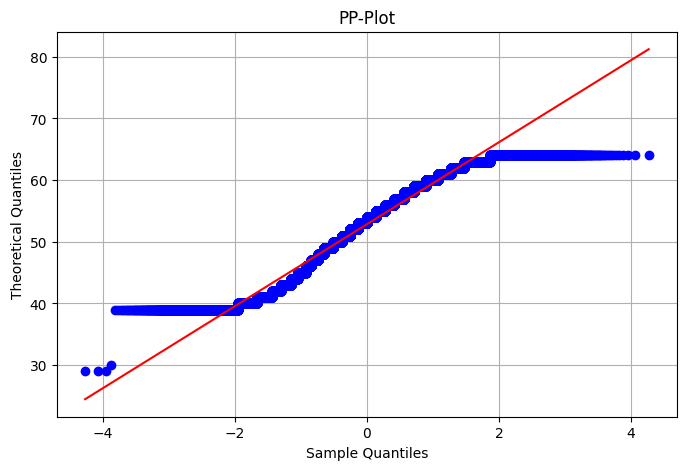

Data points on a straight line suggest a normally distributed data.
= = = = = = = = = = = = = = = = = = = = height = = = = = = = = = = = = = = = = = = = =
Mean: 164.40007781733863
Standard_deviation: 7.594937069344425


Normality Test Stats: 263.3729150475722
Normality Test P-value: 6.44611658647424e-58
We reject the null hypothesis (alpha=0.05), data likely not normally distributed.


Skewness: 0.08897141539701561
Kurtosis: -0.21605050039789564


Skewness:
  - Values close to 0 suggest a symmetrical distribution.
  - Values between +/- 0.5 suggest moderate skewness.
  - Values more extreme indicate high skewness (positive for right skew, negative for left skew).


Kurtosis:
  - Values close to 3 indicate a normal distribution (mesokurtic).
  - Values less than 3 (platykurtic) indicate a flatter distribution than normal.
  - Values greater than 3 (leptokurtic) indicate a more peaked distribution than normal.




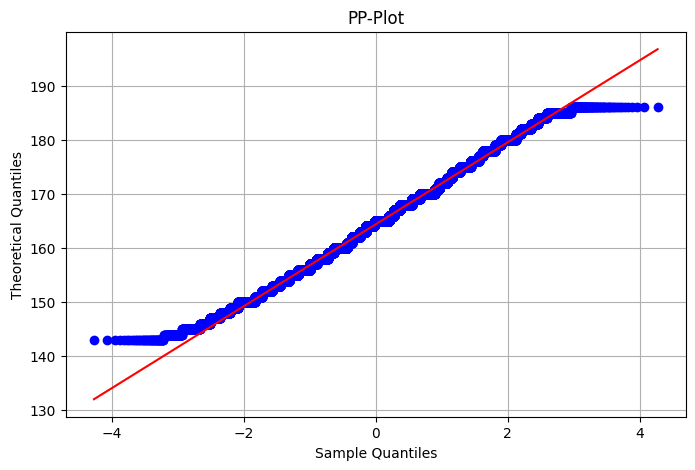

Data points on a straight line suggest a normally distributed data.
= = = = = = = = = = = = = = = = = = = = weight = = = = = = = = = = = = = = = = = = = =
Mean: 73.08791822436737
Standard_deviation: 12.277227466800813


Normality Test Stats: 1605.0337687005003
Normality Test P-value: 0.0
We reject the null hypothesis (alpha=0.05), data likely not normally distributed.


Skewness: 0.3753905690065077
Kurtosis: -0.1404040164256699


Skewness:
  - Values close to 0 suggest a symmetrical distribution.
  - Values between +/- 0.5 suggest moderate skewness.
  - Values more extreme indicate high skewness (positive for right skew, negative for left skew).


Kurtosis:
  - Values close to 3 indicate a normal distribution (mesokurtic).
  - Values less than 3 (platykurtic) indicate a flatter distribution than normal.
  - Values greater than 3 (leptokurtic) indicate a more peaked distribution than normal.




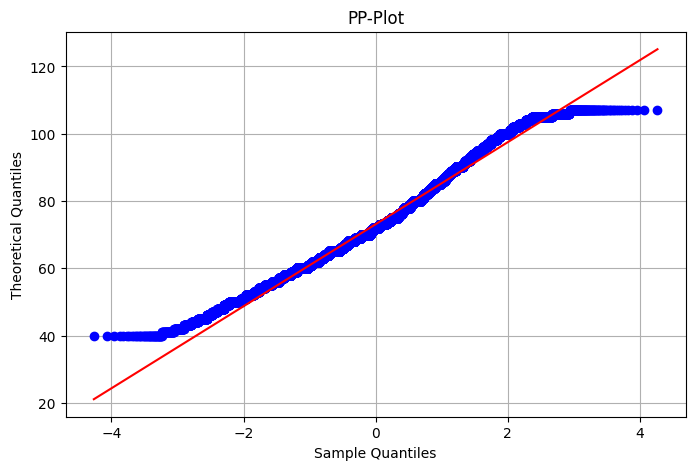

Data points on a straight line suggest a normally distributed data.
= = = = = = = = = = = = = = = = = = = = ap_hi = = = = = = = = = = = = = = = = = = = =
Mean: 126.18645449253
Standard_deviation: 15.24435622690057


Normality Test Stats: 3255.7733205144377
Normality Test P-value: 0.0
We reject the null hypothesis (alpha=0.05), data likely not normally distributed.


Skewness: 0.5489921361267079
Kurtosis: 0.27527774387897397


Skewness:
  - Values close to 0 suggest a symmetrical distribution.
  - Values between +/- 0.5 suggest moderate skewness.
  - Values more extreme indicate high skewness (positive for right skew, negative for left skew).


Kurtosis:
  - Values close to 3 indicate a normal distribution (mesokurtic).
  - Values less than 3 (platykurtic) indicate a flatter distribution than normal.
  - Values greater than 3 (leptokurtic) indicate a more peaked distribution than normal.




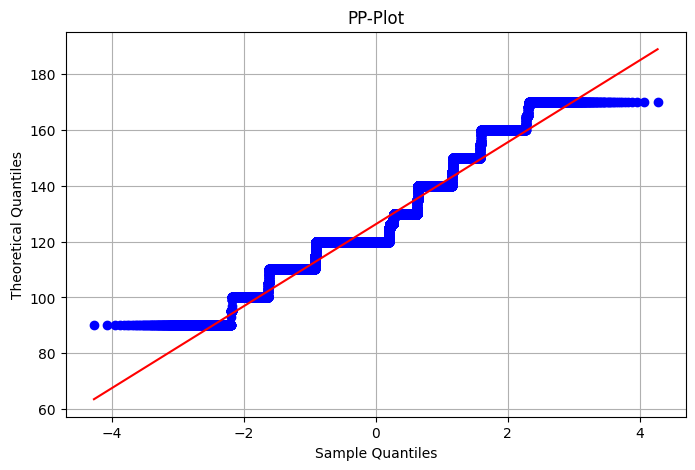

Data points on a straight line suggest a normally distributed data.
= = = = = = = = = = = = = = = = = = = = ap_lo = = = = = = = = = = = = = = = = = = = =
Mean: 81.9295213705241
Standard_deviation: 7.567034632749276


Normality Test Stats: 2438.2980390226776
Normality Test P-value: 0.0
We reject the null hypothesis (alpha=0.05), data likely not normally distributed.


Skewness: 0.4700858072427618
Kurtosis: 0.20897601772824448


Skewness:
  - Values close to 0 suggest a symmetrical distribution.
  - Values between +/- 0.5 suggest moderate skewness.
  - Values more extreme indicate high skewness (positive for right skew, negative for left skew).


Kurtosis:
  - Values close to 3 indicate a normal distribution (mesokurtic).
  - Values less than 3 (platykurtic) indicate a flatter distribution than normal.
  - Values greater than 3 (leptokurtic) indicate a more peaked distribution than normal.




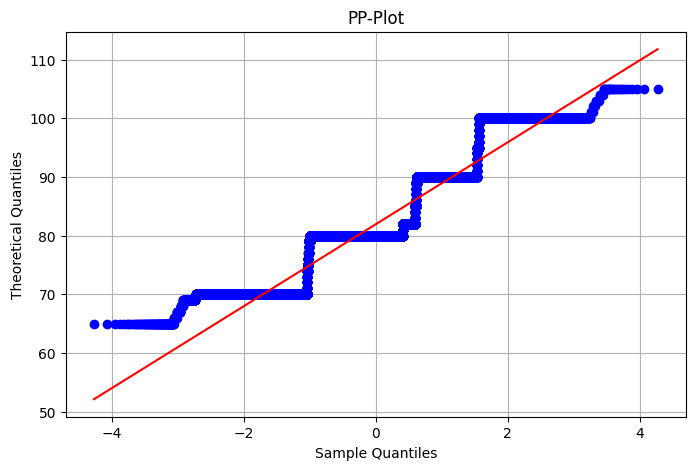

Data points on a straight line suggest a normally distributed data.


In [20]:
# Checking distribution of continuous variables
for col in cardio_base.drop(['gender','cholesterol','smoke'],axis=1):
    print(20*'= '+col+20*' =')
    normality_test(cardio_base[col].values)

In [21]:
# #applying power transformation (Box-Cox) to normalize our data
# for col in cardio_base.drop(['gender','cholesterol','smoke'],axis=1):
    
#     #transformed_data, lambda_val= stats.boxcox(cardio_base[col])
#     print(20*'='+col+20*'=')
#     #print(f'lamda_value============={lambda_val}\n')
#     normality_test(transformed_data)

In [27]:
corr = cardio_base.drop(['gender','smoke','cholesterol'],axis=1).corr('spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask

C:\Users\1916256\AppData\Local\Temp\ipykernel_67560\3032394468.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

<AxesSubplot: >

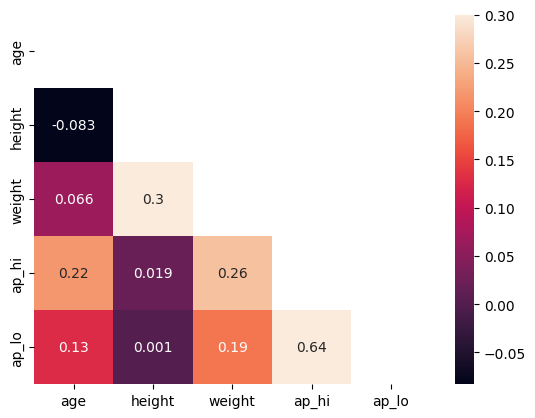

In [40]:
# Checking Spearman Correlation for continuous variable
mask = np.zeros_like(corr, dtype=bool) #create same shape False matrix as corr
mask[np.triu_indices_from(mask)] = True #np.triu_indices_from(mask) generates indices for upper tri matrix and assing True(excluding diagonal)
sns.heatmap(cardio_base.drop(['gender','smoke','cholesterol'],axis=1).corr('spearman'),mask=mask,annot=True,vmax=.3)

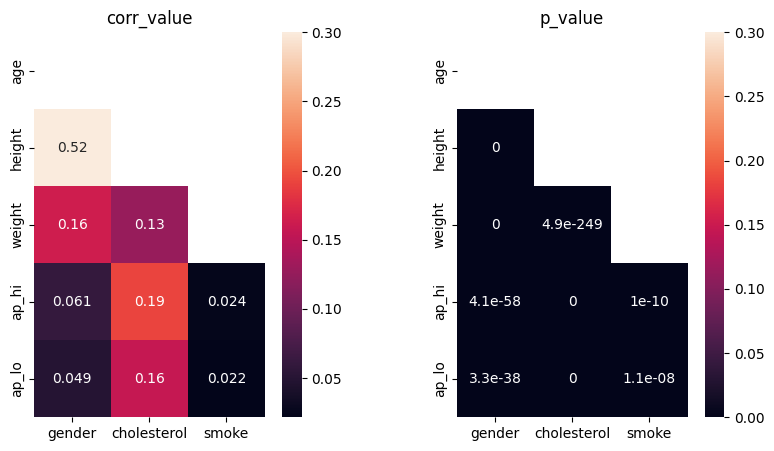

In [47]:
#Checking point-biserial corr between categorical and continuous variable
corr_df=pd.DataFrame(index=cardio_base.drop(['gender','smoke','cholesterol'],axis=1).columns)
p_df=corr_df.copy(deep=True)
cont_cols=cardio_base.drop(['gender','smoke','cholesterol'],axis=1)
for col in cardio_base:
    if cardio_base[col].nunique()<=5:
        corr_,p_=[],[]
        for colm in cont_cols :
            corr, p=stats.pointbiserialr(cardio_base[col].values,cardio_base[colm].values)
            corr_.append(corr)
            p_.append(p)
            #p_.append('p<0.05' if p<0.05 else 'p>0.05')
        corr_df[col]=corr_
        p_df[col]=p_
fig=plt.figure(figsize=(10,5))
ax1=plt.subplot(1,2,1,title='corr_value')

mask = np.zeros_like(corr_df, dtype=bool) #create same shape False matrix as corr
mask[np.triu_indices_from(mask)] = True #np.triu_indices_from(mask) generates indices for upper tri matrix and assing True(excluding diagonal)
sns.heatmap(corr_df,annot=True,mask=mask,vmax=0.3,square=True)
ax2=plt.subplot(1,2,2,title='p_value')

mask = np.zeros_like(p_df, dtype=bool) #create same shape False matrix as corr
mask[np.triu_indices_from(mask)] = True #np.triu_indices_from(mask) generates indices for upper tri matrix and assing True(excluding diagonal)
sns.heatmap(p_df,annot=True,mask=mask,vmax=0.3,square=True)
plt.show()

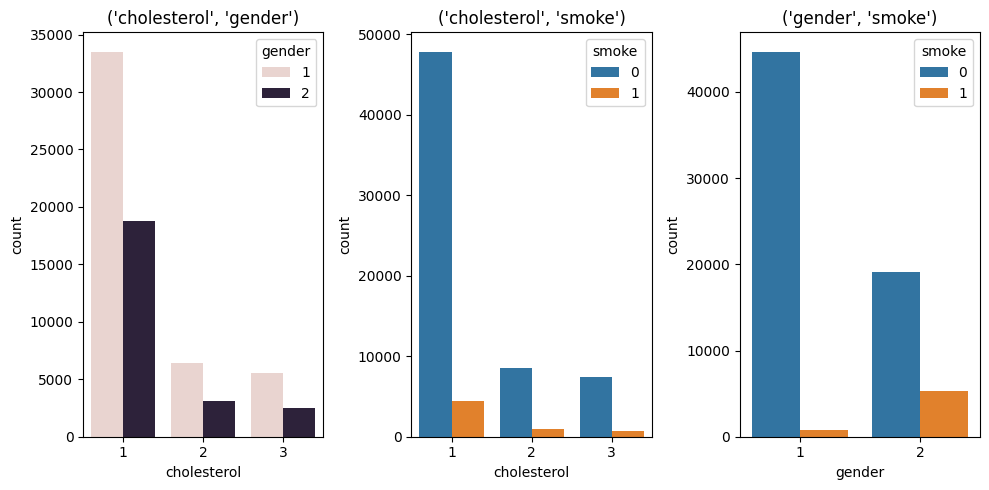

In [48]:
#check counts under each categorical variable
cat_cols=['cholesterol','gender','smoke',]
fig=plt.figure(figsize=(10,5),layout='tight')
for i,combo in enumerate(itertools.combinations(cat_cols,2),1):
    ax=plt.subplot(1,3,i,title=combo)
    sns.countplot(data=cardio_base,x=combo[0],hue=combo[1])
plt.show()

In [50]:
#Chi2 stats for categorical variables

print('++++++++++++++Smoke-Cholesterol++++++++++++++')
ct = pd.crosstab(cardio_base['smoke'],cardio_base['cholesterol'])
print('Actual values\n',ct,'\n')
chi2_stat, p, dof, expected = stats.chi2_contingency(ct)
print(f"chi2 stat : {chi2_stat: .5g}")
print(f"p-val: {p:.5g}")
print(f"dof : {dof}")
print("expected:\n", expected,'\n')


print('+++++++++++++Smoke-Gender++++++++++')
ct = pd.crosstab(cardio_base['smoke'],cardio_base['gender'])
print('Actual values\n',ct,'\n')
chi2_stat, p, dof, expected = stats.chi2_contingency(ct)
print(f"chi2 stat : {chi2_stat: .5g}")
print(f"p-val: {p:.5g}")
print(f"dof : {dof}")
print("expected:\n", expected,'\n')


print('+++++++++++Gender-Cholesterol++++++++++')
ct = pd.crosstab(cardio_base['gender'],cardio_base['cholesterol'])
print('Actual values\n',ct,'\n')
chi2_stat, p, dof, expected = stats.chi2_contingency(ct)
print(f"chi2 stat : {chi2_stat: .5g}")
print(f"p-val: {p:.5g}")
print(f"dof : {dof}")
print("expected:\n", expected)

++++++++++++++Smoke-Cholesterol++++++++++++++
Actual values
 cholesterol      1     2     3
smoke                         
0            47860  8539  7369
1             4462  1009   697 

chi2 stat :  42.134
p-val: 7.0912e-10
dof : 2
expected:
 [[47707.46533974  8705.91489362  7354.61976664]
 [ 4614.53466026   842.08510638   711.38023336]] 

+++++++++++++Smoke-Gender++++++++++
Actual values
 gender      1      2
smoke               
0       44668  19100
1         813   5355 

chi2 stat :  7995.2
p-val: 0
dof : 1
expected:
 [[41469.80679478 22298.19320522]
 [ 4011.19320522  2156.80679478]] 

+++++++++++Gender-Cholesterol++++++++++
Actual values
 cholesterol      1     2     3
gender                        
1            33522  6402  5557
2            18800  3146  2509 

chi2 stat :  91.37
p-val: 1.4428e-20
dof : 2
expected:
 [[34026.20799016  6209.28546099  5245.50654884]
 [18295.79200984  3338.71453901  2820.49345116]]


In [ ]:
# # load statmodels functions
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # compute the vif for all given features
# def compute_vif(X):
#     vif = pd.DataFrame()
#     vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     vif['variable'] = X.columns
#     return vif.sort_values('VIF',ascending=False)

In [ ]:
# compute_vif(cardio_base.drop(['cholesterol','ap_lo','height','ap_hi'],axis=1))

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(cardio_base.drop('smoke',axis=1),cardio_base['smoke'],test_size=0.2,random_state=10)